# Example 2 Fashion MNIST classification with PNN and PAT

In this notebook, we show how a physical neural network can be constructed out of coupled nonlinear oscillators to perform the Fashion MNIST task. The main goals of this notebook is to have a self-contained jupyter notebook that walks through the following key steps involved in training a physical neural network via physics aware training.  

- Defining a parametrized input-output map for both the physical and the differentiable digital model
- Constructing the custom autograd function necessary for PAT
- Constructing and training a physical neural network with the custom PAT function at hand
- Load the trained model and visualize the results

For this example, we consider a physical neural network based on coupled nonlinear oscillators. Here we consider all-to-all connected coupled nonlinear oscillators that obeys the following equations of motion. 

$$ \frac{\mathrm{d}^2q_i}{\mathrm{d} t^2} = -\sin{q_i} + \sum_{j=1}^N J_{ij}\left( \sin{q_j} - \sin{q_i} \right) +e_i $$ 
where $q_i$ are the oscillator amplitudes, $J_{ij}$ are the coupling coefficients (which must be symmetric, i.e., $J_{ij}=J_{ji}$), and $e_i$ are individual oscillator drives. For simplicity, we assume that both the coupling and drives are constants (not functions of time $t$).

The oscillator system is turned into a PNN by the following input-output map. We encode the data into the initial amplitudes, and the output is taken to be state of the oscillator after some time-evolution. We choose to set the first derivatives to 0, so the system begins at rest $\dot q_i (t=0) = 0$. Finally, the trainable parameters of the PNN are the coupling constants between the oscillators and the drives, $J_{ij}$, i.e., $\vec{\theta} = [J_{11}, J_{12}, \ldots, J_{NN}, e_1, \ldots e_N]$.

We model the noise present in setting the initial oscillator amplities in an experiment via $q_i(t=0) = x_i + n_i$, where $n_i$ is sampled from a normal distribution of 0.02 standard deviation. Since the initial oscillator amplitude is order unity, this corresponds to about 2\% of noise.

In order to simulate the effect of the mismatch between model and experiment that is addressed by physics-aware training, we add noise to (a) the nonlinearity coefficient, and (b) the coupling coefficients $J_{ij}$. Thus, while the model remains described by the equation above, the physical system is described by:
$$    \frac{\mathrm{d}^2q_i}{\mathrm{d} t^2} = -\sin({(1+\eta)q_i}) + \sum_{j=1}^N (J_{ij}+J^{\mathrm{noise}}_{ij})\left( \sin({(1+\eta)q_j}) - \sin({(1+\eta) q_i}) \right) +e_i $$

Because capturing locality of the image data present in the Fashion MNIST data is important, we consider the following PNN architecture. Here each 28x28 image is divided into 16 patches of 49 pixels each. Each patch is then processed by a **small, 100 oscillator network**. These output are all combined later all concatenated into a 1600 oscillator vector, which is then processed a **larger, 1610 oscillator network**. 

To begin, the notebook will now define the input-output maps associated with both the small and large oscillator networks that are generated from the differential equations above. 

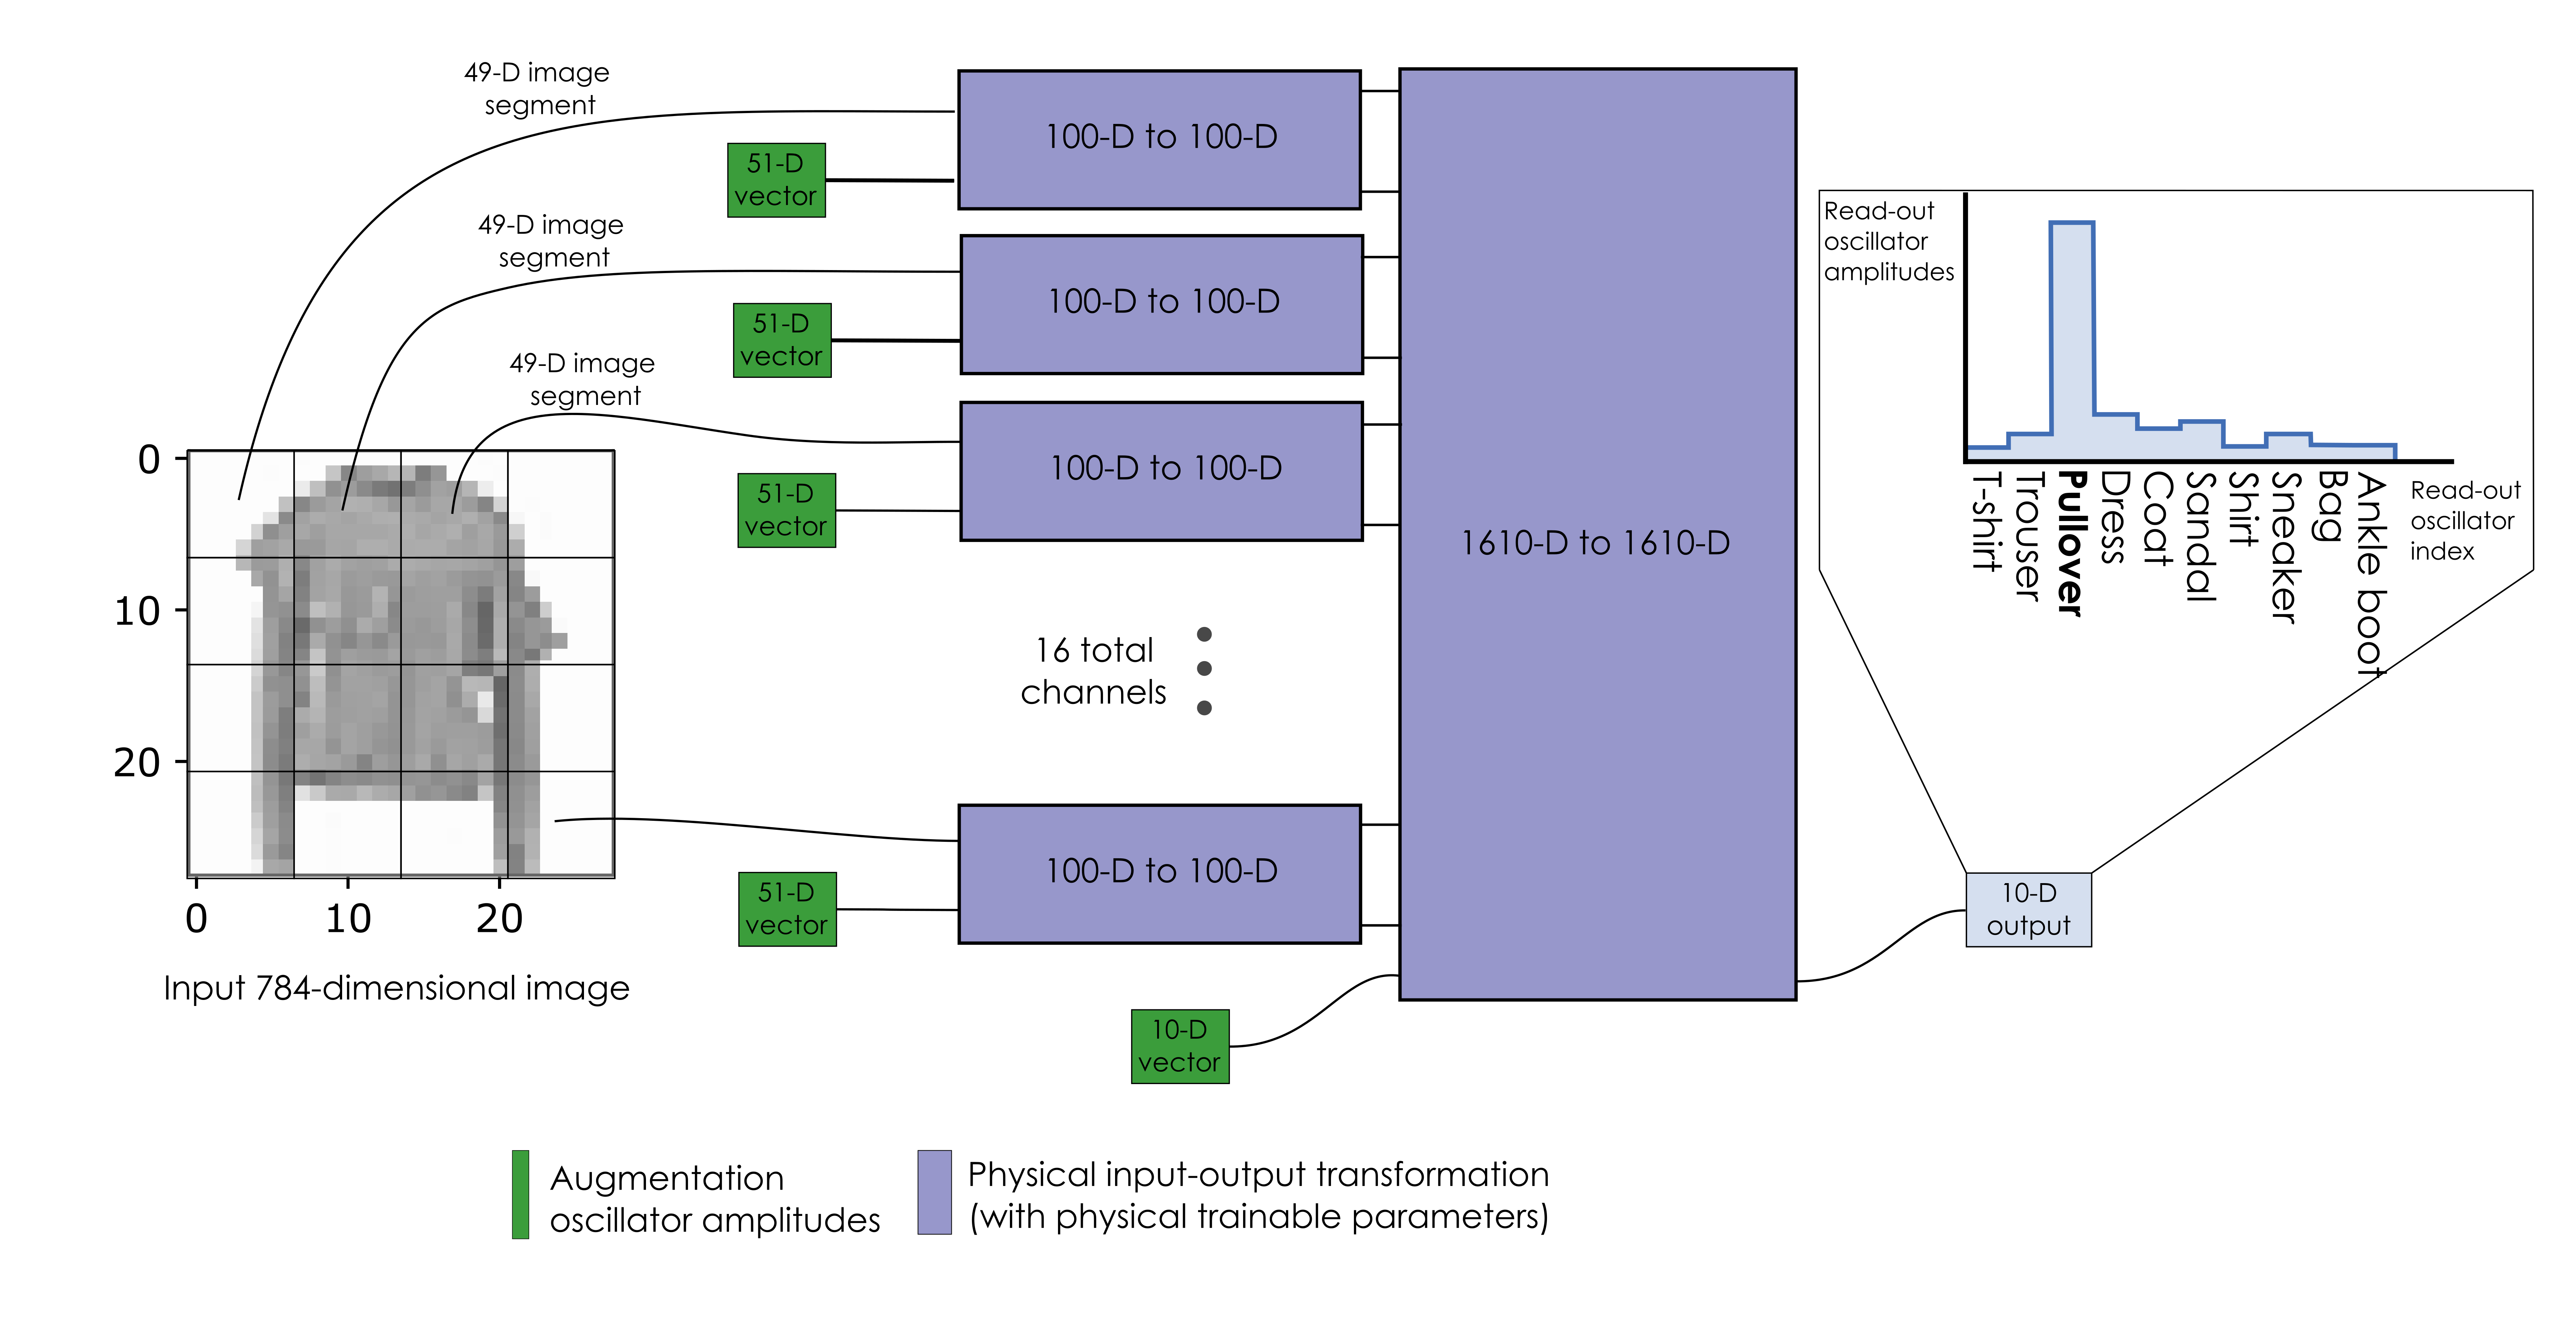

### Parameters of the architecture and simulation

In [1]:
device = 0 #use "cpu" if running on CPU, enter the GPU number if running on GPU -- Note: It's important that device is an integer is the GPU case!

#parameters associated with the architecture
image_size = 28
patch_size = 7
dim_small = 100 #dimension of the small oscillator network
num_patches = (image_size // patch_size) ** 2
dim_large = dim_small*num_patches+10 #dimension of the large oscillator network

## Defining the input-output maps

To impose the constraint that the condition that the coupling coefficients $J_{ij}$ is symmetric, we take the following approach of building in this constraint by constructing $J$ from the relation $J = (C + C^\text{T})/2$, where $\text{T}$ is the transpose operation. Here, $C$ is a N by N matrix (that we will generate through the ```nn.Linear``` class), which we can now train without any constraints. 

Finally, for notationally simplicity, we also introduce a new matrix $Q$ such that the offdiagonal elements of $Q$ are that of $J$ and the diagonal elements are given by $Q_{ii} = -\sum_j J_{ij}$. Using this matrix, the equations of motion can be simplified into a matrix multiplication as follows:
$$ \frac{\mathrm{d}^2q_i}{\mathrm{d} t^2} = -\sin{q_i} + \sum_{j=1}^N Q_{ij}\sin{q_j} +e_i $$ 

In [2]:
import torch

#defining an effective J matrix to speed up the computation
def C2Q(C):
    Q = (C + C.T)/2
    C_colsum = -torch.sum(Q, axis=0)
    inds = list(range(C.shape[0]))
    Q[inds, inds] = C_colsum
    return Q

#Define the ODE for the model with this Qmatrix
#Note this ODE can be used as a model for both the small and large oscillator network
def ode_model(z, C, e):
    Q = C2Q(C)
    q = z[..., 0]
    p = z[..., 1]
    output = torch.empty_like(z)
    output[..., 0] = p
    sin_q = torch.sin(q)
    output[..., 1] = -sin_q + e + sin_q@Q
    return output

We emulate the simulation-reality gap, by introducing an additional "noise" coupling matrix $Q_{\text{noise}}$, and by changing the nonlinearity of the network by a factor $\eta$. The ODE for the experiment (forward-pass of the PNN) is given by

$$ \frac{\mathrm{d}^2q_i}{\mathrm{d} t^2} = -\sin[{(1+\eta)q_i}] + e_i + \sum_{j=1}^N Q_{ij}\sin{[(1+\eta)q_j]} + \sum_{j=1}^N Q_{\text{noise},ij}\sin{[(1+\eta)q_j]} $$ 

In [3]:
#parameters associated with noise
J_noise = 0.2
η = 0.1
input_noise = 0.02

#Since the small and large networks require different noise coupling matrix, two separate
#ODE needs to be defined.

torch.manual_seed(0)
# Define the noise coupling matrice for the small network. This is fixed during training and testing. 
Q_noise_small = C2Q(J_noise*torch.randn(dim_small, dim_small)).to(device)

#Define the "experiment" ODE for the small oscillator network
def ode_exp_small(z, C, e):
    Q = C2Q(C)
    q = z[..., 0]
    p = z[..., 1]
    output = torch.empty_like(z)
    output[..., 0] = p
    sin_q = torch.sin((1+η)*q)
    output[..., 1] = -sin_q + e + sin_q@Q + sin_q@Q_noise_small
    return output

# Define the noise coupling matrice for the large network. This is fixed during training and testing. 
Q_noise_large = C2Q(J_noise*torch.randn(dim_large, dim_large)).to(device)

#Define the "experiment" ODE for the large oscillator network
def ode_exp_large(z, C, e):
    Q = C2Q(C)
    q = z[..., 0]
    p = z[..., 1]
    output = torch.empty_like(z)
    output[..., 0] = p
    sin_q = torch.sin((1+η)*q)
    output[..., 1] = -sin_q + e + sin_q@Q + sin_q@Q_noise_large
    return output

#Function to generate the input noise of setting the initial oscillator amplitudes
#Used later when definining the PNN.
def make_noise(x):
    n_tensor = torch.zeros_like(x)
    n_tensor[..., 0] = input_noise*torch.randn(x.shape[:-1])
    return n_tensor

In [4]:
#import functions from utils.py for solving ODEs
from ode_utils import make_ode_map
# make_ode_map is a function that returns the ode_map function, which takes
# in the initial condition x and returns the final state of the ODE after 
# evolving by time Nt*dt. 

#parameters associated with the ODE solver
Nt = 5 #checked that 5 points converges - (same classification accuracy is achieved)
t_end = 0.5 #how long the ODE is time-evolved for
dt = t_end/Nt #discretization step for the ODE solver


#The following 3 blocks of code define the forward and backward functions 
#for a given layer of the PNN. It does this by first generating the 
#ode_map given each corresponding ode.

#The differential digital model for the parameterized input output map of the small oscillator network 
f_model = make_ode_map(ode_model, Nt, dt)

#The parameterized physical input output map of the small oscillator network 
f_exp_small = make_ode_map(ode_exp_small, Nt, dt)

#The differential digital model for the parameterized input output map of the large oscillator network 
f_exp_large = make_ode_map(ode_exp_large, Nt, dt)

#Function arguments of f_model, f_exp_small, f_exp_large is identical
#It is given by f(x, C, e), 
#where x is the input data, C is the coupling matrix of the network (as used in ode),
#and e is the bias

Given the specification of the physical (forward) functions $f_\text{p}$ and model (backward) function $f_\text{m}$, we can use these to define the physics-aware training custom autograd function $f_\text{PAT}$

In [5]:
from pat import make_pat_func

#this code is used to construct the PAT functions
f_pat_small = make_pat_func(f_exp_small, f_model)
f_pat_large = make_pat_func(f_exp_large, f_model)

## Constructing and training a physical neural network 

### Loading the Fashion MNIST dataset

In [6]:
## Vanilla code for loading the Fashion MNIST dataset
batch_size = 32
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor()])

transform_val = transforms.Compose([transforms.ToTensor()])

train_set = (FashionMNIST( root = 'ml_dataset', train = True,
            download = True, transform = transform_train ))

val_set = (FashionMNIST( root = 'ml_dataset', train = False,
            download = True, transform = transform_val ))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

/usr/local/anaconda/envs/NN_v2/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


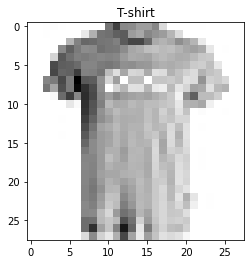

In [7]:
#Visualize one instance of the dataset

import matplotlib.pylab as plt

torch.manual_seed(0)
x, y = next(iter(train_loader))

labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", 
          "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

ind = 3

plt.imshow(x[ind].reshape(28, 28), cmap="binary")
plt.title(labels[y[ind]]);

### Defining the PNN architecture and training the PNN

To define the pytorch module as well as the train a given model to perform the Fashion MNIST task, we uses the [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) package. This package effectively allows us to perform the full training loop with minimal code, in addition to performing the logging of the training and the parameters of the trained model.

**Important**: Pytorch-lightning is a rapidly evolving package, thus it is very important to be operating with the correct version of it. To make sure that the correct version is installed, install the package by running the following command in a jupyter notebook cell. Note that the ```!``` will run a terminal command from the notebook.

```!pip install pytorch-lightning==0.9.0```. 

To segment the image into patches, it is convenient to use the ```einops``` package, which allows for the complex manipulation of tensors. Any reasonably up-to-date version should work, but to download the version originally used for development, run the following command in a jupyter notebook cell. 

```!pip install einops==0.3.0```

In [8]:
import pytorch_lightning as pl

if pl.__version__ != '0.9.0':
    print("Warning! The version of pytorch-lightning that you have installed is not 0.9.0. Please see installation instructions above")

In [9]:
from pytorch_lightning.metrics import Accuracy
import torch.nn.functional as F
import torch

from einops.layers.torch import Rearrange, Reduce
import torch.nn as nn
import torch.optim as optim

class PNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', 
                              p1 = patch_size, p2 = patch_size)
        self.fc_small = nn.Linear(dim_small, dim_small)
        self.fc_large = nn.Linear(dim_large, dim_large)
        self.output_fac = nn.Parameter(torch.tensor(1.0).float())
        self.accu_metric = Accuracy()
        
    def forward(self, x):
        #converts the [Nbatch, 1, 28, 28] tensor to the tensor with the 16 patches of 49-dimensional vectors with shape [Nbatch, 16, 49]
        x = self.rearrange(x)
        
        #augmenting the data vector to include the velocity vector, i.e. dot q = 0
        x = torch.stack([x, torch.zeros_like(x)], dim=-1) 
        #augmenting zeros to the patch_size**2 dimensional vector to get a dim_small dimensional vector
        x = torch.cat([x, torch.zeros([*x.shape[:-2], dim_small-patch_size**2, 2] 
                                      , device=x.device)], dim=-2)
        #Add noise to the initial condition
        x += make_noise(x)
        
        #Because of broadcasting, this simple line of code is really running the 
        #16 uses of the small oscillator in parallel.
        x = f_pat_small(x, *self.fc_small.parameters())
        
        #Get the positions of the pendulums
        x = x[..., 0]
        #Flatten the output vector
        x = x.view(x.size(0), -1)
        
        #Augmenting the data vector to include the velocity vector, i.e. dot q = 0
        x = torch.stack([x, torch.zeros_like(x)], dim=2)
        #Augmenting the initial conditions, which are zeros, of the "class oscillators"
        x = torch.cat([x, torch.zeros([x.shape[0], 10, 2], device=x.device)], dim=1)
        #Add noise to the initial condition
        x += make_noise(x) 
        
        #Use the large oscillator network to obtain a 10-dimensional vector 
        x = f_pat_large(x, *self.fc_large.parameters())
        
        #return the positions of the "class oscillators"
        x = self.output_fac*(x[:, -10:, 0])
        return x
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters())
        return optimizer
    
    #The following code defines the how the training loop will be performed by pytorch-lightning
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = F.cross_entropy(out, y) 
        y_pred = torch.max(out, 1)[1]
        accuracy = self.accu_metric(y_pred, y)

        result = pl.TrainResult(loss)
        result.log('train_loss', torch.sqrt(loss))
        result.log('train_accu', accuracy)
        return result
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = F.cross_entropy(out, y) 
        y_pred = torch.max(out, 1)[1]
        accuracy = self.accu_metric(y_pred, y)

        result = pl.EvalResult(checkpoint_on=accuracy)
        result.log('val_loss', loss)
        result.log('val_accu', accuracy)
        
        #Some additional code for printing the current progress
        if batch_idx == 0:
            if not hasattr(self, 'started_training'):
                print('Starting training')
                self.started_training=True
            else:
                print(f'Currently training Epoch {self.trainer.current_epoch+1} \nTo see real time results, see training_logs/[folder]/[subfolder]/metrics.csv file\r') 
        
        return result

In [10]:
model = PNN().to(device)

#check that the module does successfully run
x, y = next(iter(train_loader))
print(f"output dimensions of PNN is {model(x.to(device)).shape}")

output dimensions of PNN is torch.Size([32, 10])


### Training configuration
The training for this model takes about an hour on a GPU.  Note that the user can interrupt the training and visualize the intermediate results (and rerun at a later time).

If the user wants the skip the training and load the trained model - please skip these cells and run the cells in the next section.

In [11]:
#If train_flag == True -- the following cell of training will run 
#If train_flag == False -- the code will skip the training, and the section below on visualizing the results will load in precomputed results
train_flag = False

In [12]:
log_dir = "training_logs"
if train_flag:
    #defines where the training curve is saved + where the model is saved
    #please feel free to rename the folder and subfolder, that will determine the name of the log
    folder =  "new_results"
    subfolder = "FMNIST_v1"
    
else: 
    folder = "precomputed_results" #load in precomputed results (that was uploaded to github)
    subfolder = "FMNIST"           #FMNIST results
    
import os, glob
data_dir = os.path.join(log_dir, folder, subfolder) #the datadirectory where the data is saved

if train_flag:
    logger = pl.loggers.CSVLogger(log_dir, folder, subfolder)

    max_epochs = 20 #the number of epochs to train for

    #the following block is responsible for checkpointing the model, which will be loaded in later.
    checkpoint_file = os.path.join(log_dir, folder, subfolder, "{epoch}-{val_accu:.2f}")
    checkpoint_cb = pl.callbacks.ModelCheckpoint(checkpoint_file, mode="max")
    [os.remove(ckpt) for ckpt in glob.glob(os.path.join(data_dir,'*.ckpt'))] #remove existing ckpt files - so as to not cause overlap


    if device != "cpu":
        trainer = pl.Trainer(max_epochs=max_epochs, logger=logger, gpus=[device],
                                checkpoint_callback=checkpoint_cb, 
                                weights_summary=None, progress_bar_refresh_rate=0)
    else:
        trainer = pl.Trainer(max_epochs=max_epochs, logger=logger,
                                checkpoint_callback=checkpoint_cb, 
                                weights_summary=None, progress_bar_refresh_rate=0)

    trainer.fit(model, train_loader, val_loader)

## Visualize results

In [13]:
import glob
import os
#load the parameters of the model
# data_dir = "precomputed_results/Example3/trial3"

ckpt = glob.glob(os.path.join(data_dir,'*.ckpt'))[0] #it uses glob to find the checkpoint file

if device != "cpu":
    save_dict = torch.load(ckpt, map_location=f"cuda:{device}")
else:
    save_dict = torch.load(ckpt, map_location="cpu")
state_dict = save_dict["state_dict"]
state_dict.keys()

model = PNN().to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

### Plot the trained coupling matrices and internal dynamics present in the oscillator network

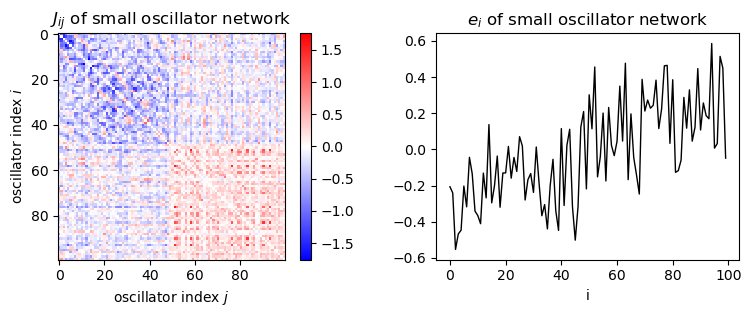

In [14]:
Q_small = C2Q(state_dict["fc_small.weight"])
e_small = state_dict["fc_small.bias"]

J_small = Q_small.clone()

for i in range(J_small.shape[0]):
    J_small[i,i]=0.0

fig, axs = plt.subplots(1, 2, figsize=(9, 3), dpi=100)
fig.subplots_adjust(wspace=0.3)

plt.sca(axs[0])
vmax = torch.max(torch.abs(J_small)).cpu()
plt.imshow((J_small.cpu()), vmax=vmax, vmin=-vmax, cmap="bwr", interpolation="nearest")
plt.colorbar()
plt.ylabel(r"oscillator index $i$")
plt.xlabel(r"oscillator index $j$")
plt.title(r"$J_{ij}$ of small oscillator network")

plt.sca(axs[1])
plt.plot(e_small.cpu(), "k", lw=1)
plt.xlabel("i")
plt.title(r"$e_{i}$ of small oscillator network");

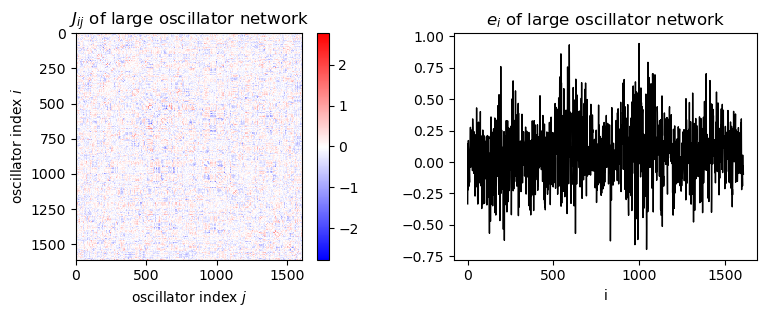

In [15]:
Q_large = C2Q(state_dict["fc_large.weight"])
e_large = state_dict["fc_large.bias"]

J_large = Q_large.clone()

for i in range(J_large.shape[0]):
    J_large[i,i]=0.0

fig, axs = plt.subplots(1, 2, figsize=(9, 3), dpi=100)

fig.subplots_adjust(wspace=0.3)

plt.sca(axs[0])
vmax = torch.max(torch.abs(J_large)).cpu()
plt.imshow((J_large).cpu(), vmax=vmax, vmin=-vmax, cmap="bwr", interpolation="nearest")
plt.colorbar()
plt.ylabel(r"oscillator index $i$")
plt.xlabel(r"oscillator index $j$")
plt.title(r"$J_{ij}$ of large oscillator network")

plt.sca(axs[1])
plt.plot(e_large.cpu(), "k", lw=1)
plt.xlabel("i")
plt.title(r"$e_{i}$ of large oscillator network");

0 T-shirt


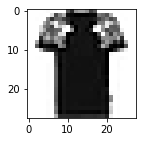

In [16]:
from ode_utils import ode_map_all_points
#ode_map_all_points solves an ODE and also returns the 
#intermediate state vectors during the ODE evolution.
#This is useful for visualizing the dynamics of the model after training.

#parameters related to how much discretization is used for visualizing the ODE evolution
Nt_visual = 100
dt_visual = t_end/Nt_visual
tlist = torch.linspace(0, t_end, Nt_visual)

import numpy as np
import matplotlib.cm as cm

torch.manual_seed(4)
x, y = next(iter(val_loader))

plt.figure(figsize=(2,2))
ind = 4 #ind chooses the image that is fed into the PNN for visualization
img = x[ind, :].numpy()
target = y[ind].numpy()
print(target, labels[target])

plt.imshow(img[0], cmap="binary");

self = model.to(device)
x = x.to(device)

#converts the [Nbatch, 1, 28, 28] tensor to the tensor with the 16 patches of 49-dimensional vectors with shape [Nbatch, 16, 49]
x = self.rearrange(x)

#augmenting the data vector to include the velocity vector, i.e. dot q = 0
x = torch.stack([x, torch.zeros_like(x)], dim=-1) 
#augmenting zeros to the patch_size**2 dimensional vector to get a dim_small dimensional vector
x = torch.cat([x, torch.zeros([*x.shape[:-2], dim_small-patch_size**2, 2] 
                              , device=x.device)], dim=-2)
#Add noise to the initial condition
x += make_noise(x)

#Because of broadcasting, this simple line of code is really running the 
#16 uses of the small oscillator in parallel.

x = f_pat_small(x, *self.fc_small.parameters())

#Get the positions of the pendulums
x = x[..., 0]
#Flatten the output vector
x = x.view(x.size(0), -1)

#Augmenting the data vector to include the velocity vector, i.e. dot q = 0
x = torch.stack([x, torch.zeros_like(x)], dim=2)
#Augmenting the initial conditions, which are zeros, of the "class oscillators"
x = torch.cat([x, torch.zeros([x.shape[0], 10, 2], device=x.device)], dim=1)
#Add noise to the initial condition
x += make_noise(x)

#Use the large oscillator network to obtain a 10-dimensional vector
xlist = ode_map_all_points(ode_exp_large, x, 
                     Nt_visual, dt_visual, *self.fc_large.parameters())

(0.0, 0.5)

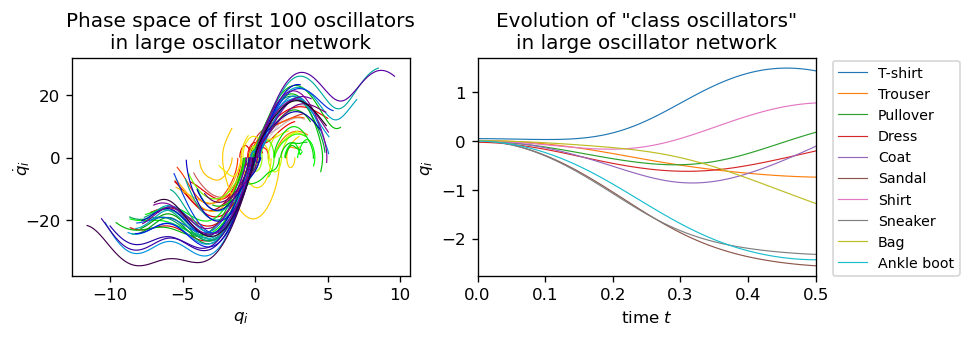

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2.4), dpi=120)

plt.sca(axs[0])
plt.title("Phase space of first 100 oscillators\nin large oscillator network")
for osc_ind in range(100):
    q = [x[ind, osc_ind, 0].cpu().detach() for x in xlist]
    p = [x[ind, osc_ind, 1].cpu().detach() for x in xlist]
    
    plt.plot(q, p, color=cm.nipy_spectral_r(osc_ind/100), lw=0.7)
    plt.ylabel(r"$\dot q_i$", labelpad=-5)
    plt.xlabel(r"$q_i$")
    
plt.sca(axs[1])
plt.title("Evolution of \"class oscillators\"\nin large oscillator network")
for (i, traj) in enumerate(xlist[:, ind, -10:, 0].T):
    plt.plot(tlist, traj.detach().cpu(), color=cm.tab10(i/10), label=f"{labels[i]}", lw=0.7)
plt.legend(loc=(1.05, 0.0), ncol=1, fontsize=8.5)
plt.xlabel(r"time $t$")
plt.ylabel(r"$q_i$")
plt.xlim(0, t_end)

### Plot the training curve and confusion matrix

This requires sci-kit v0.23.1, though in practice, any moderately up-to-date version should work. 

if the user wants to install this version of sklearn run the following code in a cell below (the ```!``` will run a terminal command)

```!pip install scikit-learn==0.23.1```

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sklearn.metrics as metrics

In [20]:
#the following code runs the trained model on examples from the validation set
#to construct a confusion matrix
torch.manual_seed(0)
x, y = [], []
for xi, yi in list(val_loader):
    x.append(xi)
    y.append(yi)

Nx = 2000
x = torch.cat(x, dim = 0)[:Nx, :].to(device)
target = torch.cat(y, dim = 0)[:Nx]

with torch.no_grad():
    out = model(x)
pred = torch.max(out, 1)[1].cpu()

#the following code makes sure that only 100 example of each class is taken for the confusion matrix
Ndig = 100
target_eq=list()
pred_eq=list()
count = np.zeros(10)
for idx in range(len(pred)):
    ti=target[idx]
    yi=pred[idx]
    count[ti]+=1
    if count[ti]<=Ndig:
        target_eq.append(ti)
        pred_eq.append(yi)
conf = metrics.confusion_matrix(target_eq, pred_eq);

In [21]:
#load the training curve
import pandas as pd
df = pd.read_csv(os.path.join(data_dir, "metrics.csv"))
#Filter out the rows which does not have validation accuracy information with mask
mask = [not(x) for x in np.isnan(df["val_accu"].values)]
epoch = df["epoch"].values[mask]
accu = df["val_accu"].values[mask]

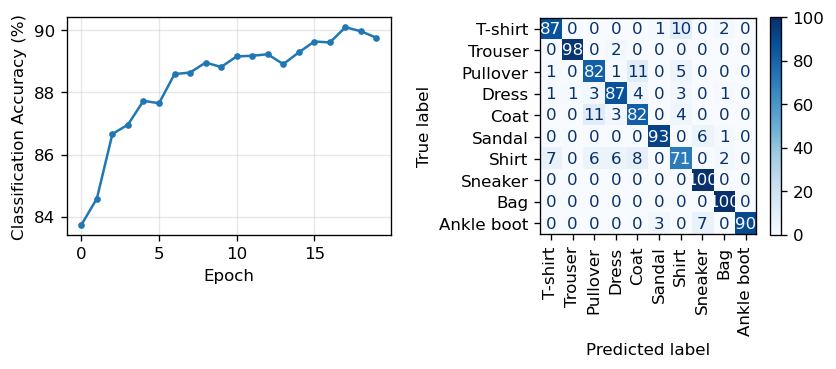

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 2, figsize=(8, 2.4), 
                    gridspec_kw=dict(width_ratios=[0.6, 0.5]), dpi=120)

fig.subplots_adjust(wspace=0.5)
plt.sca(axs[0])
plt.plot(epoch, accu*100, ".-")
plt.grid(alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy (%)")

plt.sca(axs[1])
disp = ConfusionMatrixDisplay(conf, display_labels=labels)
size = 1
disp.plot(cmap=cm.Blues, ax=plt.gca(), values_format="d", xticks_rotation='vertical');